# Importação de bibliotecas

In [1]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from classifiers.bayesian_classifier import BayesianGaussianClassifier
from utils.classifier_utils import ClassifierUtils
from utils.dataset_utils import DatasetUtils
from utils.image_generator import ImageGenerator

# Definição de constantes

In [2]:
np.random.seed(42)
CLASSIFIER_NAME = "Bayesian Gaussian"
TARGET_COLUMN_NAME = "class"
DATASET_NAME = "Iris"
TEST_SIZE = 0.2
HOLDOUT_INDEXES_NUMBER = 200
FIG_SIZE = (12, 10)
IMAGE_FONT_SIZE = 20
RESOLUTION_POINTS = 1000

# Baixando dataset Iris

In [3]:
iris = fetch_ucirepo(id=53)

X_iris = iris.data.features
y_iris = iris.data.targets

iris_df = pd.concat([X_iris, y_iris], axis="columns")

In [4]:
list(iris_df[TARGET_COLUMN_NAME].unique())

['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

# Redefinindo classes para valores numéricos

In [5]:
class_mapping = {"Iris-setosa": 0, "Iris-versicolor": 1, "Iris-virginica": 2}
iris_df[TARGET_COLUMN_NAME] = iris_df[TARGET_COLUMN_NAME].map(class_mapping)
iris_df[TARGET_COLUMN_NAME]

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: class, Length: 150, dtype: int64

# Treinamento e avaliação dos modelos, juntamente com a criação de tabela de métricas para o classificador Bayesiano

In [6]:
bayesian_holdout_indexes = ClassifierUtils.create_multiple_holdout_indexes(
    df=iris_df, n_indexes=HOLDOUT_INDEXES_NUMBER, test_size=TEST_SIZE
)

bayesian_accuracy_list = []

for train_indexes, test_indexes in bayesian_holdout_indexes:
    X_train, y_train, X_test, y_test = ClassifierUtils.separate_train_test(
        df=iris_df,
        train_indexes=train_indexes,
        test_indexes=test_indexes,
        target_column_name=TARGET_COLUMN_NAME,
    )

    classifier = BayesianGaussianClassifier()
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test=X_test)

    accuracy = ClassifierUtils.calculate_accuracy(y_true=y_test, y_pred=y_pred)
    error_rate = ClassifierUtils.calculate_error_rate(y_true=y_test, y_pred=y_pred)

    confusion_matrix_result = ClassifierUtils.confusion_matrix(
        y_true=y_test, y_pred=y_pred
    )

    bayesian_accuracy_list.append(
        (
            accuracy,
            error_rate,
            train_indexes,
            test_indexes,
            y_pred,
            confusion_matrix_result,
        )
    )

bayesian_df_results = pd.DataFrame(
    bayesian_accuracy_list,
    columns=[
        "accuracy",
        "error_rate",
        "train_indexes",
        "test_indexes",
        "y_pred",
        "confusion_matrix",
    ],
)

bayesian_df_results

,accuracy,error_rate,train_indexes,test_indexes,y_pred,confusion_matrix
0,1.000000,0.000000,"[73, 18, 118, 78, 76, 31, 64, 141, 68, 82, 110...","[1, 129, 130, 140, 14, 144, 20, 21, 149, 37, 4...","[0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 1, 1, 1, ...","[[7, 0, 0], [0, 11, 0], [0, 0, 12]]"
1,0.900000,0.100000,"[84, 20, 45, 47, 149, 114, 144, 117, 9, 90, 14...","[128, 129, 2, 133, 138, 12, 140, 142, 143, 26,...","[2, 2, 0, 1, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, ...","[[9, 0, 0], [0, 6, 2], [0, 1, 12]]"
2,0.966667,0.033333,"[54, 71, 117, 30, 58, 81, 10, 64, 51, 28, 131,...","[129, 133, 134, 7, 135, 141, 145, 18, 146, 20,...","[2, 1, 2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, ...","[[10, 0, 0], [0, 5, 0], [0, 1, 14]]"
3,1.000000,0.000000,"[51, 101, 131, 129, 106, 121, 141, 105, 37, 12...","[0, 1, 3, 135, 9, 140, 15, 143, 146, 149, 22, ...","[0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, ...","[[13, 0, 0], [0, 9, 0], [0, 0, 8]]"
4,0.966667,0.033333,"[120, 110, 123, 94, 6, 129, 76, 51, 82, 47, 13...","[0, 131, 5, 134, 136, 142, 144, 18, 24, 32, 35...","[0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[10, 0, 0], [0, 8, 1], [0, 0, 11]]"
...,...,...,...,...,...,...
195,1.000000,0.000000,"[84, 47, 26, 81, 60, 90, 23, 18, 65, 10, 146, ...","[1, 3, 131, 135, 137, 138, 11, 21, 149, 38, 42...","[0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 1, 1, 1, ...","[[7, 0, 0], [0, 11, 0], [0, 0, 12]]"
196,0.966667,0.033333,"[2, 17, 135, 103, 123, 87, 10, 130, 88, 105, 1...","[132, 5, 7, 137, 138, 13, 142, 15, 143, 21, 23...","[2, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, ...","[[11, 0, 0], [0, 8, 1], [0, 0, 10]]"
197,0.966667,0.033333,"[86, 59, 62, 93, 47, 115, 73, 111, 103, 24, 14...","[5, 6, 7, 139, 15, 17, 145, 19, 147, 148, 28, ...","[0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, ...","[[12, 0, 0], [0, 6, 1], [0, 0, 11]]"
198,0.966667,0.033333,"[49, 17, 66, 0, 58, 77, 105, 30, 133, 52, 147,...","[129, 131, 5, 135, 139, 12, 13, 15, 16, 18, 14...","[2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, ...","[[9, 0, 0], [0, 4, 1], [0, 0, 16]]"


# Vetor de acurácias

In [7]:
bayesian_accuracy_vector = pd.Series(bayesian_df_results["accuracy"])

In [8]:
bayesian_accuracy_vector

0      1.000000
1      0.900000
2      0.966667
3      1.000000
4      0.966667
         ...   
195    1.000000
196    0.966667
197    0.966667
198    0.966667
199    0.933333
Name: accuracy, Length: 200, dtype: float64

# Definindo gerador de imagens

In [9]:
image_generator = ImageGenerator(figure_size=FIG_SIZE, font_size=IMAGE_FONT_SIZE)

# Boxplot das acurácias do classificador Bayesiano

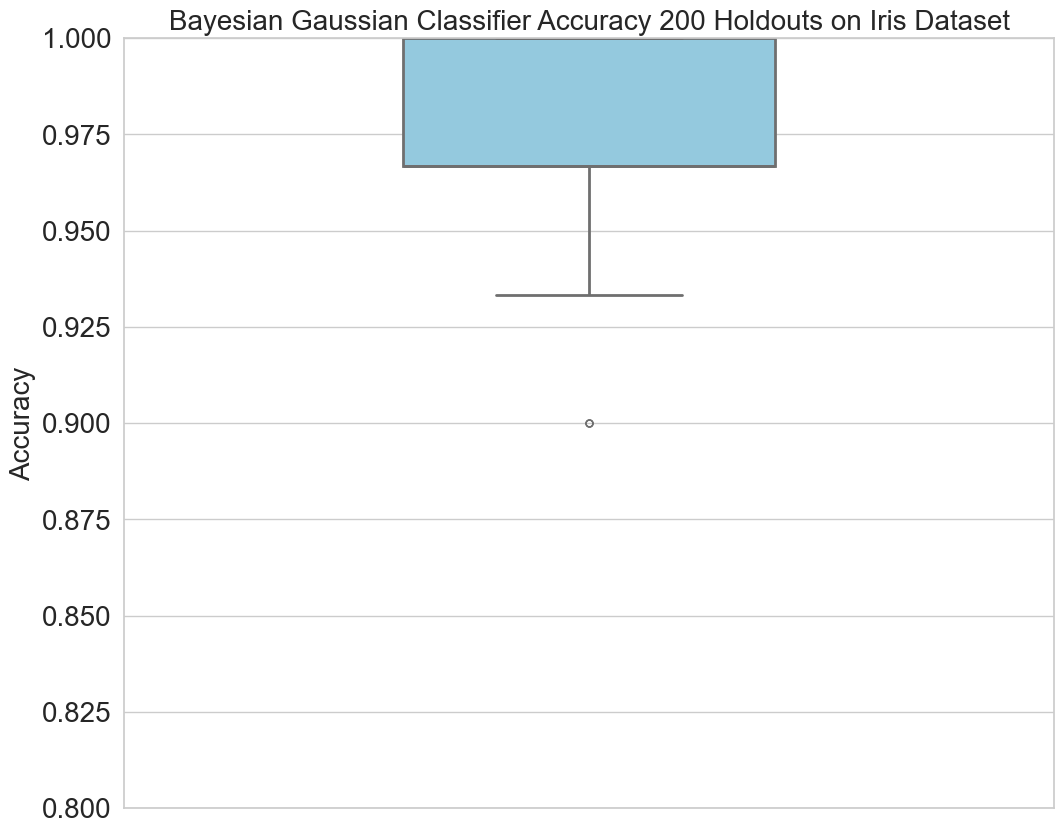

In [10]:
image_generator.create_boxplot(
    vector_distribution=bayesian_accuracy_vector,
    y_label="Accuracy",
    image_title=f"{CLASSIFIER_NAME} Classifier Accuracy {HOLDOUT_INDEXES_NUMBER} Holdouts on {DATASET_NAME} Dataset",
    path_to_save="../../data/images/atividade_2/iris_bayesian_accuracy_boxplot.jpeg",
    show=True,
)

# Baseado na melhor acurácia, pego os índices de treino e teste que geraram ela e calculo a superfície de decisão e também resgato a sua respectiva matriz de confusão

In [11]:
max_accuracy = bayesian_df_results["accuracy"].max()
indexes_of_max_accuracy = bayesian_df_results[
    bayesian_df_results["accuracy"] == max_accuracy
].index.tolist()

index_selected = np.random.choice(indexes_of_max_accuracy)

print(f"Índice(s) com melhor acurácia: {indexes_of_max_accuracy}")
print(f"Índice selecionado aleatoriamente: {index_selected}")
print(f"Acurácia do índice selecionado: {max_accuracy * 100:.2f}%")

best_accuracy_train_indexes = bayesian_df_results.loc[index_selected, "train_indexes"]
best_accuracy_test_indexes = bayesian_df_results.loc[index_selected, "test_indexes"]

X_train, y_train, X_test, y_test = ClassifierUtils.separate_train_test(
    df=iris_df,
    train_indexes=best_accuracy_train_indexes,
    test_indexes=best_accuracy_test_indexes,
    target_column_name=TARGET_COLUMN_NAME,
)

Índice(s) com melhor acurácia: [0, 3, 5, 8, 10, 13, 14, 15, 17, 23, 24, 25, 28, 29, 30, 31, 32, 37, 39, 42, 43, 45, 46, 56, 58, 59, 60, 65, 67, 69, 71, 72, 73, 83, 85, 88, 91, 93, 94, 95, 97, 107, 108, 110, 114, 115, 117, 119, 120, 121, 122, 123, 126, 129, 131, 134, 137, 138, 139, 141, 145, 152, 153, 155, 157, 158, 159, 163, 165, 168, 171, 176, 177, 178, 179, 180, 183, 184, 188, 190, 191, 192, 195]
Índice selecionado aleatoriamente: 180
Acurácia do índice selecionado: 100.00%


# Resgatando a matriz de confusão e plotando ela

In [12]:
confusion_matrix_result = bayesian_df_results.loc[index_selected, "confusion_matrix"]

In [13]:
confusion_matrix_result

array([[10,  0,  0],
       [ 0,  8,  0],
       [ 0,  0, 12]])

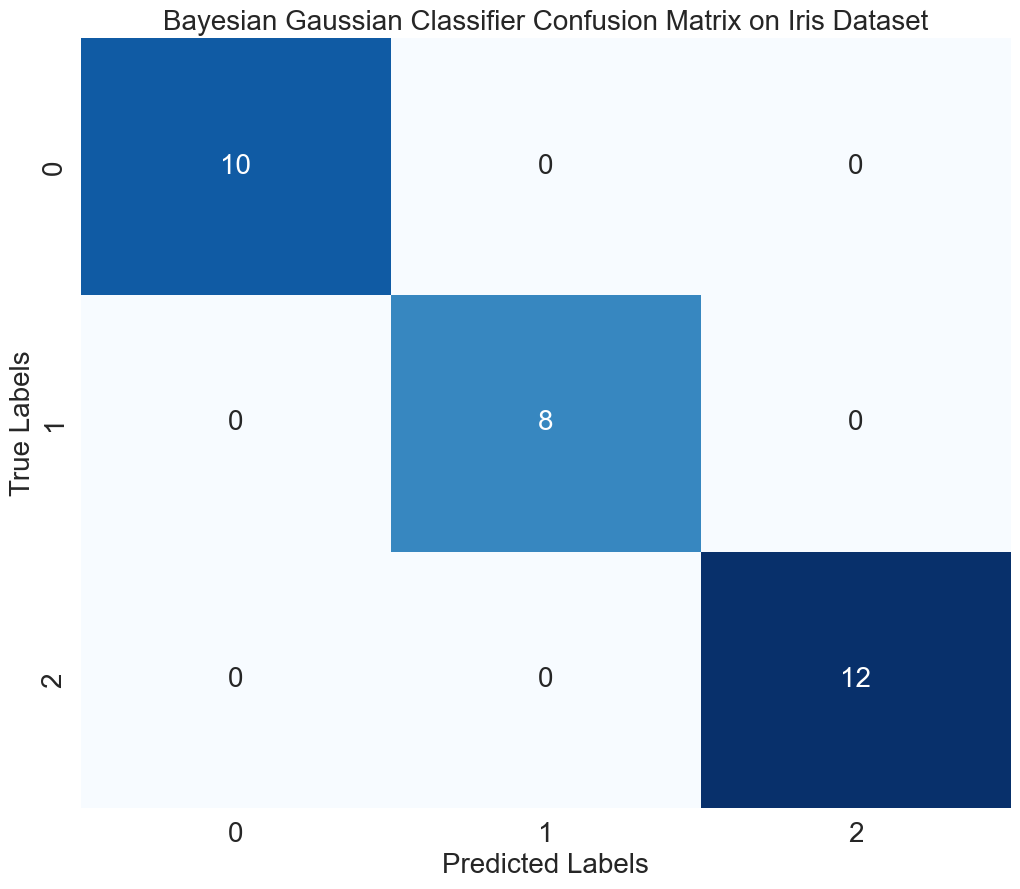

In [14]:
image_generator.create_confusion_matrix_heatmap(
    confusion_matrix=confusion_matrix_result,
    x_label="Predicted Labels",
    y_label="True Labels",
    image_title=f"{CLASSIFIER_NAME} Classifier Confusion Matrix on {DATASET_NAME} Dataset",
    path_to_save="../../data/images/atividade_2/iris_bayesian_confusion_matrix.jpeg",
    show=True,
)

# Calculo de superfície de decisão para o classificador Bayesiano baseado em duas features

In [15]:
feature_x = X_train.columns[0]
feature_y = X_train.columns[1]

test_grid, x_shape, y_shape = DatasetUtils.create_test_grid(
    X_train=X_train,
    feature_x=feature_x,
    feature_y=feature_y,
    resolution_points=RESOLUTION_POINTS,
    return_shapes=True,
)

classifier = BayesianGaussianClassifier()
classifier.fit(X_train[[feature_x, feature_y]], y_train)

y_pred_test_grid = classifier.predict(test_grid)

y_pred_test_grid = y_pred_test_grid.reshape(x_shape)

# Plot da superfície de decisão para o classificador Bayesiano

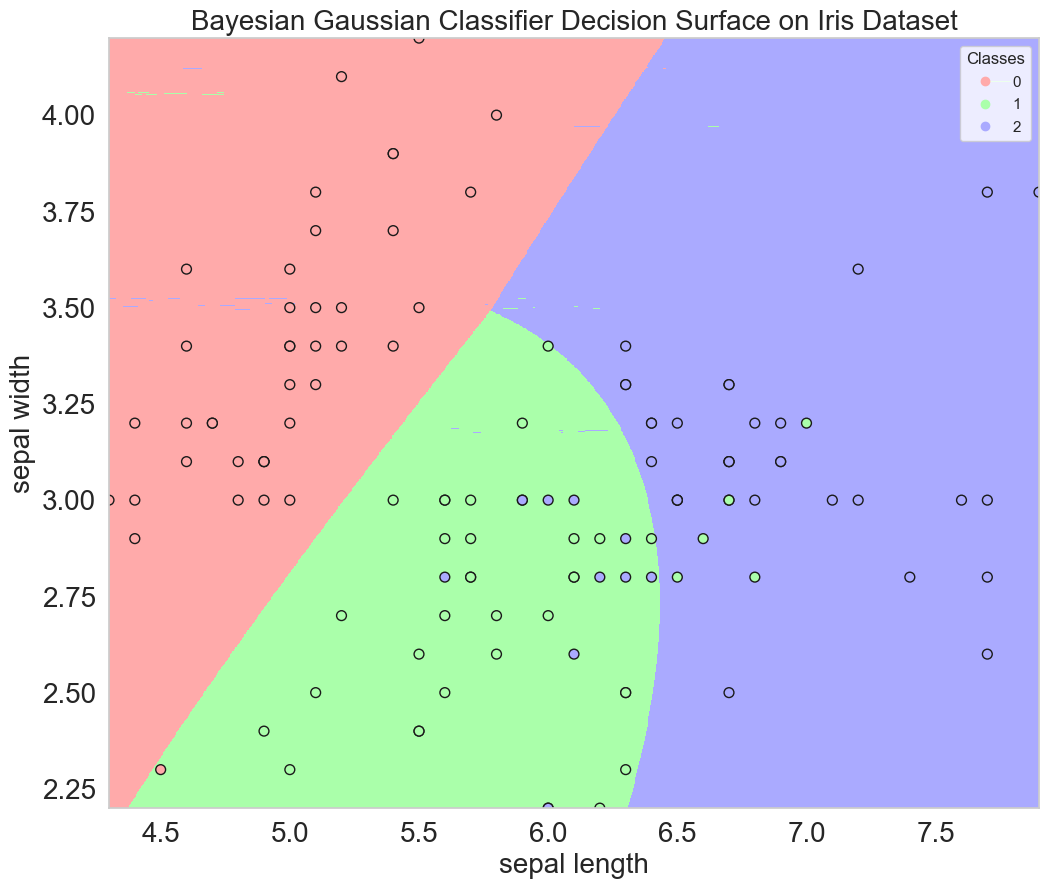

In [16]:
image_generator.create_decision_surface(
    X_train=X_train,
    y_train=y_train,
    y_pred=y_pred_test_grid,
    image_title=f"{CLASSIFIER_NAME} Classifier Decision Surface on {DATASET_NAME} Dataset",
    feature_x=feature_x,
    feature_y=feature_y,
    resolution_points=RESOLUTION_POINTS,
    path_to_save="../../data/images/atividade_2/iris_bayesian_decision_surface.jpeg",
    show=True,
)